In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from scipy.stats import linregress
from scipy import stats

The following code is from Google Earth Engine (GEE). It was easier to access the information there and do some inital data crunching before turning it into a csv to finish the project in python. Only TEMPO was used since it is geostationary and thus has multiple time stamps per day.

var HU = ee.Geometry.Point([-76.3366, 37.0203]);

var CBBT = ee.Geometry.Point([-76.0766, 37.0367]);

var larc = ee.Geometry.Point([-76.3868, 37.1036])


var tempoCollection = ee.ImageCollection("NASA/TEMPO/NO2_L3")
  .filterDate('2024-07-01', '2024-07-31') // replace with date range
  .filterBounds(larc); // replace with location of interest

//manually calculates the total column value  
var tempoWithTotal = tempoCollection.map(function(image) {
  var tropo = image.select('vertical_column_troposphere');
  var strato = image.select('vertical_column_stratosphere');

  var total = tropo.add(strato).rename('total_vertical_column');

  return image.addBands(total);
});

// creates a time series returning time, NO2 in mol/m^2 and molec/cm^2
var timeSeries = tempoWithTotal.map(function(img) {
  var band = 'total_vertical_column';
  var rawDict = img.select(band).reduceRegion({
    reducer: ee.Reducer.first(),
    geometry: larc,
    scale: 1113,
    maxPixels: 1e13
  });

  var rawVal = rawDict.get(band);
  var dateTime = ee.Date(img.get('system:time_start'));

  return ee.Algorithms.If(
    rawVal,
    ee.Feature(null, {
      'datetime': dateTime,
      'tempo_NO2_scaled': ee.Number(rawVal).multiply(1.6605e-20),
      'raw_NO2': rawVal
    }),
    ee.Feature(null, {})
  );
}).filter(ee.Filter.notNull(['datetime']));

// makes and prints out a chart to make sure data is working on this end
var chart = ui.Chart.feature
  .byFeature(timeSeries, 'datetime', 'tempo_NO2_scaled')
  .setChartType('ScatterChart')  // Optional: change to LineChart or TimeSeries if available
  .setOptions({
    title: 'NO₂ Time Series at CBBT',
    hAxis: {title: 'Date'},
    vAxis: {title: 'mol/m²'},
    pointSize: 4,
    lineWidth: 2,
    colors: ['#1f78b4']
  });

print(chart);

//exports data to csv for python
Export.table.toDrive({
  collection: timeSeries,
  description: 'TEMPO_Diurnal_LaRC',
  fileFormat: 'CSV'
});

In [4]:
# read in the csv's from above
HU_path = '../HULL/Data/TEMPO_Diurnal_HU.csv'
HU = pd.read_csv(HU_path)

CBBT_path = '../HULL/Data/TEMPO_Diurnal_CBBT.csv'
CBBT = pd.read_csv(CBBT_path)

LaRC_path = '../HULL/Data/TEMPO_Diurnal_LaRC.csv'
LaRC = pd.read_csv(LaRC_path)

#test one to make sure everything was successful
CBBT.head()

,system:index,datetime,raw_NO2,tempo_NO2_scaled,.geo
0,20240701T103402Z,2024-07-01T10:34:02,4.861524e+15,0.000081,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,20240701T111407Z,2024-07-01T11:14:07,5.252068e+15,0.000087,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,20240701T115412Z,2024-07-01T11:54:12,3.594303e+15,0.000060,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,20240701T123417Z,2024-07-01T12:34:17,2.637553e+15,0.000044,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,20240701T131422Z,2024-07-01T13:14:22,2.924500e+15,0.000049,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [5]:
# drop and rename columns as needed for ease of use
HU.drop(columns=['system:index', '.geo'], inplace=True)
HU.rename(columns={'raw_NO2': 'raw_NO2_HU', 'tempo_NO2_scaled':'HU_NO2'}, inplace=True)
HU.head()

CBBT.drop(columns=['system:index', '.geo'], inplace=True)
CBBT.rename(columns={'raw_NO2': 'raw_NO2_CBBT', 'tempo_NO2_scaled':'CBBT_NO2'}, inplace=True)
CBBT.head()

LaRC.drop(columns=['system:index', '.geo'], inplace=True)
LaRC.rename(columns={'raw_NO2': 'raw_NO2_LaRC', 'tempo_NO2_scaled':'LaRC_NO2'}, inplace=True)
LaRC.head()

,datetime,raw_NO2_LaRC,LaRC_NO2
0,2024-07-01T10:34:02,7.100412e+15,0.000118
1,2024-07-01T11:14:07,3.132795e+15,0.000052
2,2024-07-01T11:54:12,3.280615e+15,0.000054
3,2024-07-01T12:34:17,8.341620e+15,0.000139
4,2024-07-01T13:14:22,8.134013e+15,0.000135


The following three cells turn GEE DateTime into seconds since 2000 that we are working with here

In [6]:
diurnal_list = []
for doi in HU['datetime']:
    j2000_epoch = datetime(2000, 1, 1, 0, 0)
    target_date = datetime.strptime(doi, "%Y-%m-%dT%H:%M:%S")
    day = (target_date - j2000_epoch).total_seconds()/86400
    diurnal = day%1
    if diurnal < .2:
        diurnal = diurnal +1
    diurnal_list.append(diurnal)
    
HU['diurnal'] = diurnal_list
HU.head()

,datetime,raw_NO2_HU,HU_NO2,diurnal
0,2024-07-01T10:34:02,6.721991e+15,0.000112,0.440301
1,2024-07-01T11:14:07,4.116570e+15,0.000068,0.468137
2,2024-07-01T11:54:12,7.413813e+15,0.000123,0.495972
3,2024-07-01T12:34:17,5.857657e+15,0.000097,0.523808
4,2024-07-01T13:14:22,2.868512e+15,0.000048,0.551644


In [7]:
diurnal_list = []
for doi in CBBT['datetime']:
    j2000_epoch = datetime(2000, 1, 1, 0, 0)
    target_date = datetime.strptime(doi, "%Y-%m-%dT%H:%M:%S")
    day = (target_date - j2000_epoch).total_seconds()/86400
    diurnal = day%1
    if diurnal < .2:
        diurnal = diurnal +1
    diurnal_list.append(diurnal)
    
CBBT['diurnal'] = diurnal_list
CBBT.head()

,datetime,raw_NO2_CBBT,CBBT_NO2,diurnal
0,2024-07-01T10:34:02,4.861524e+15,0.000081,0.440301
1,2024-07-01T11:14:07,5.252068e+15,0.000087,0.468137
2,2024-07-01T11:54:12,3.594303e+15,0.000060,0.495972
3,2024-07-01T12:34:17,2.637553e+15,0.000044,0.523808
4,2024-07-01T13:14:22,2.924500e+15,0.000049,0.551644


In [8]:
diurnal_list = []
for doi in LaRC['datetime']:
    j2000_epoch = datetime(2000, 1, 1, 0, 0)
    target_date = datetime.strptime(doi, "%Y-%m-%dT%H:%M:%S")
    day = (target_date - j2000_epoch).total_seconds()/86400
    diurnal = day%1
    if diurnal < .2:
        diurnal = diurnal +1
    diurnal_list.append(diurnal)
    
LaRC['diurnal'] = diurnal_list
LaRC.head()

,datetime,raw_NO2_LaRC,LaRC_NO2,diurnal
0,2024-07-01T10:34:02,7.100412e+15,0.000118,0.440301
1,2024-07-01T11:14:07,3.132795e+15,0.000052,0.468137
2,2024-07-01T11:54:12,3.280615e+15,0.000054,0.495972
3,2024-07-01T12:34:17,8.341620e+15,0.000139,0.523808
4,2024-07-01T13:14:22,8.134013e+15,0.000135,0.551644


In [9]:
# Remove outliers using the 1.5*IQR method for each location


# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = HU['HU_NO2'].quantile(0.25)
Q3 = HU['HU_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_HU = HU[(HU['HU_NO2'] >= lower_bound) & (HU['HU_NO2'] <= upper_bound)]


# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = CBBT['CBBT_NO2'].quantile(0.25)
Q3 = CBBT['CBBT_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_CBBT = CBBT[(CBBT['CBBT_NO2'] >= lower_bound) & (CBBT['CBBT_NO2'] <= upper_bound)]



# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = LaRC['LaRC_NO2'].quantile(0.25)
Q3 = LaRC['LaRC_NO2'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_LaRC = LaRC[(LaRC['LaRC_NO2'] >= lower_bound) & (LaRC['LaRC_NO2'] <= upper_bound)]

In [10]:
date=[]
HU_mean=[]
HU_error = []
CBBT_mean=[]
CBBT_error = []
LaRC_mean = []
LaRC_error = []

#Arranges values by time of day, regardless of the day/month. This goes from 5am to 5am the following day at 30 minute intervals. 
#It calculates the mean and error for each 30 min bin at each location

for i in np.arange(5/24, 1+5/24, 1/48):
    avg = np.nanmean(cleaned_HU.loc[(cleaned_HU['diurnal'] >= i)&(cleaned_HU['diurnal'] < i+(1/48)), 'HU_NO2'])
    std = np.nanstd(cleaned_HU.loc[(cleaned_HU['diurnal'] >= i)&(cleaned_HU['diurnal'] < i+(1/48)), 'HU_NO2'])
    size = cleaned_HU.loc[(cleaned_HU['diurnal'] >= i) & (cleaned_HU['diurnal'] < i + (1/48)), 'HU_NO2'].count()
    sem = std / np.sqrt(size)
    confidence_level = 0.95 # for a 95% confidence interval
    degrees_freedom = size - 1
    conf_interval = stats.t.interval(confidence_level, degrees_freedom, loc=avg, scale=sem)
    error = (conf_interval[1] - conf_interval[0]) / 2
    HU_mean.append(avg)
    HU_error.append(error)
    
    avg = np.nanmean(cleaned_CBBT.loc[(cleaned_CBBT['diurnal'] >= i)&(cleaned_CBBT['diurnal'] < i+(1/48)), 'CBBT_NO2'])
    std = np.nanstd(cleaned_CBBT.loc[(cleaned_CBBT['diurnal'] >= i)&(cleaned_CBBT['diurnal'] < i+(1/48)), 'CBBT_NO2'])
    size = cleaned_CBBT.loc[(cleaned_CBBT['diurnal'] >= i) & (cleaned_CBBT['diurnal'] < i + (1/48)), 'CBBT_NO2'].count()
    sem = std / np.sqrt(size)
    confidence_level = 0.95 # for a 95% confidence interval
    degrees_freedom = size - 1
    conf_interval = stats.t.interval(confidence_level, degrees_freedom, loc=avg, scale=sem)
    error = (conf_interval[1] - conf_interval[0]) / 2
    CBBT_error.append(error)
    CBBT_mean.append(avg)
    
    avg = np.nanmean(cleaned_LaRC.loc[(cleaned_LaRC['diurnal'] >= i)&(cleaned_LaRC['diurnal'] < i+(1/48)), 'LaRC_NO2'])
    std = np.nanstd(cleaned_LaRC.loc[(cleaned_LaRC['diurnal'] >= i)&(cleaned_LaRC['diurnal'] < i+(1/48)), 'LaRC_NO2'])
    size = cleaned_LaRC.loc[(cleaned_LaRC['diurnal'] >= i) & (cleaned_LaRC['diurnal'] < i + (1/48)), 'LaRC_NO2'].count()
    sem = std / np.sqrt(size)
    confidence_level = 0.95 # for a 95% confidence interval
    degrees_freedom = size - 1
    conf_interval = stats.t.interval(confidence_level, degrees_freedom, loc=avg, scale=sem)
    error = (conf_interval[1] - conf_interval[0]) / 2
    LaRC_error.append(error)
    LaRC_mean.append(avg)
    date.append(i)

HU_mean = np.array(HU_mean)
HU_error = np.array(HU_error)
CBBT_mean = np.array(CBBT_mean)
CBBT_error = np.array(CBBT_error)
LaRC_mean = np.array(LaRC_mean)
LaRC_error = np.array(LaRC_error)

/tmp/ipykernel_73277/2815714054.py:13: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(cleaned_HU.loc[(cleaned_HU['diurnal'] >= i)&(cleaned_HU['diurnal'] < i+(1/48)), 'HU_NO2'])
/mnt/home/sadie.mullinix/.conda/envs/cure2025/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_73277/2815714054.py:24: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(cleaned_CBBT.loc[(cleaned_CBBT['diurnal'] >= i)&(cleaned_CBBT['diurnal'] < i+(1/48)), 'CBBT_NO2'])
/tmp/ipykernel_73277/2815714054.py:35: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(cleaned_LaRC.loc[(cleaned_LaRC['diurnal'] >= i)&(cleaned_LaRC['diurnal'] < i+(1/48)), 'LaRC_NO2'])


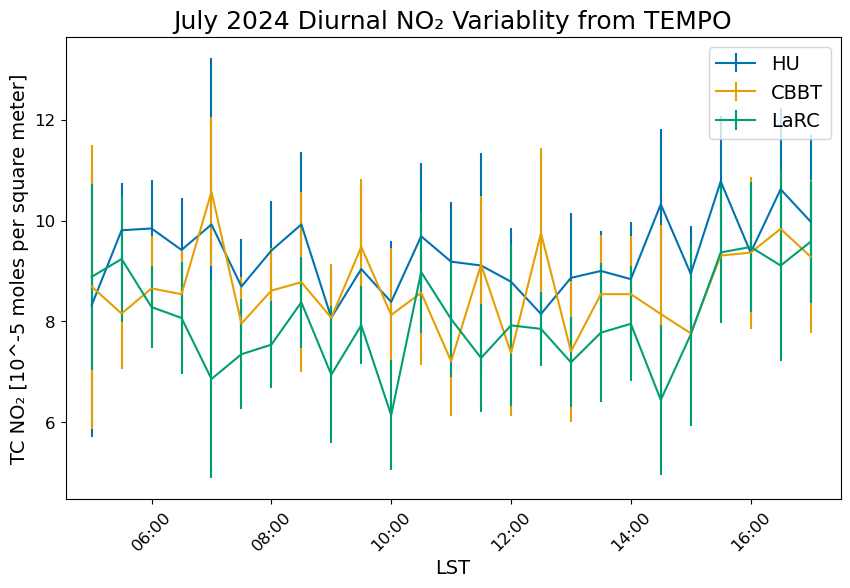

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

# this plots all three with Error Bars
ax.errorbar(date, HU_mean/10**-5, yerr = HU_error/10**-5, label = 'HU', color = '#0072B2')
ax.errorbar(date, CBBT_mean/10**-5, yerr = CBBT_error/10**-5, label = 'CBBT', color = '#E69F00')
ax.errorbar(date, LaRC_mean/10**-5, yerr = LaRC_error/10**-5, label = "LaRC", color = '#009E73')

#This makes the time of day easier to understand
fractional_day = np.arange(5/24, 1+5/24+.0005, 5/1440)
time_labels = [ (datetime(2000,1,1) + timedelta(days=frac)-timedelta(hours = 5)).time() for frac in fractional_day ]
tick_indices = np.linspace(0, len(fractional_day)-1, 13, dtype=int)
ax.set_xticks(
    fractional_day[tick_indices],
    [time_labels[i].strftime('%H:%M') for i in tick_indices],
    rotation=45
)

ax.set_xlim(.3985, .9375)
ax.legend(fontsize = 14)

ax.set_xlabel('LST', size = 14)
ax.set_ylabel('TC NO₂ [10^-5 moles per square meter]', size = 14)
ax.set_title('July 2024 Diurnal NO₂ Variablity from TEMPO', size = 18)

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.show()
#plt.savefig('Diurnal_NO2_TEMPO_July_2024.jpg', dpi=300, bbox_inches='tight')